<a href="https://colab.research.google.com/github/Mando2610/Telco-Customer-churn-Propensity-ML-Model/blob/main/TelcoChurnPropensityModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1 : Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


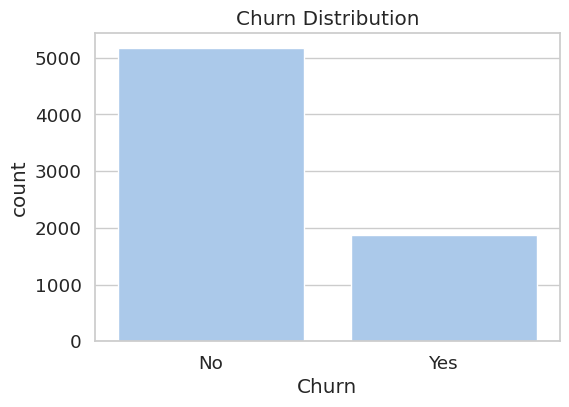

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [2]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df, color=sns.color_palette("pastel")[0])
plt.title("Churn Distribution")
plt.show()

churn_rate = df["Churn"].value_counts(normalize=True) * 100
print(churn_rate)

In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("Missing in TotalCharges:", df["TotalCharges"].isna().sum())

df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

Missing in TotalCharges: 11


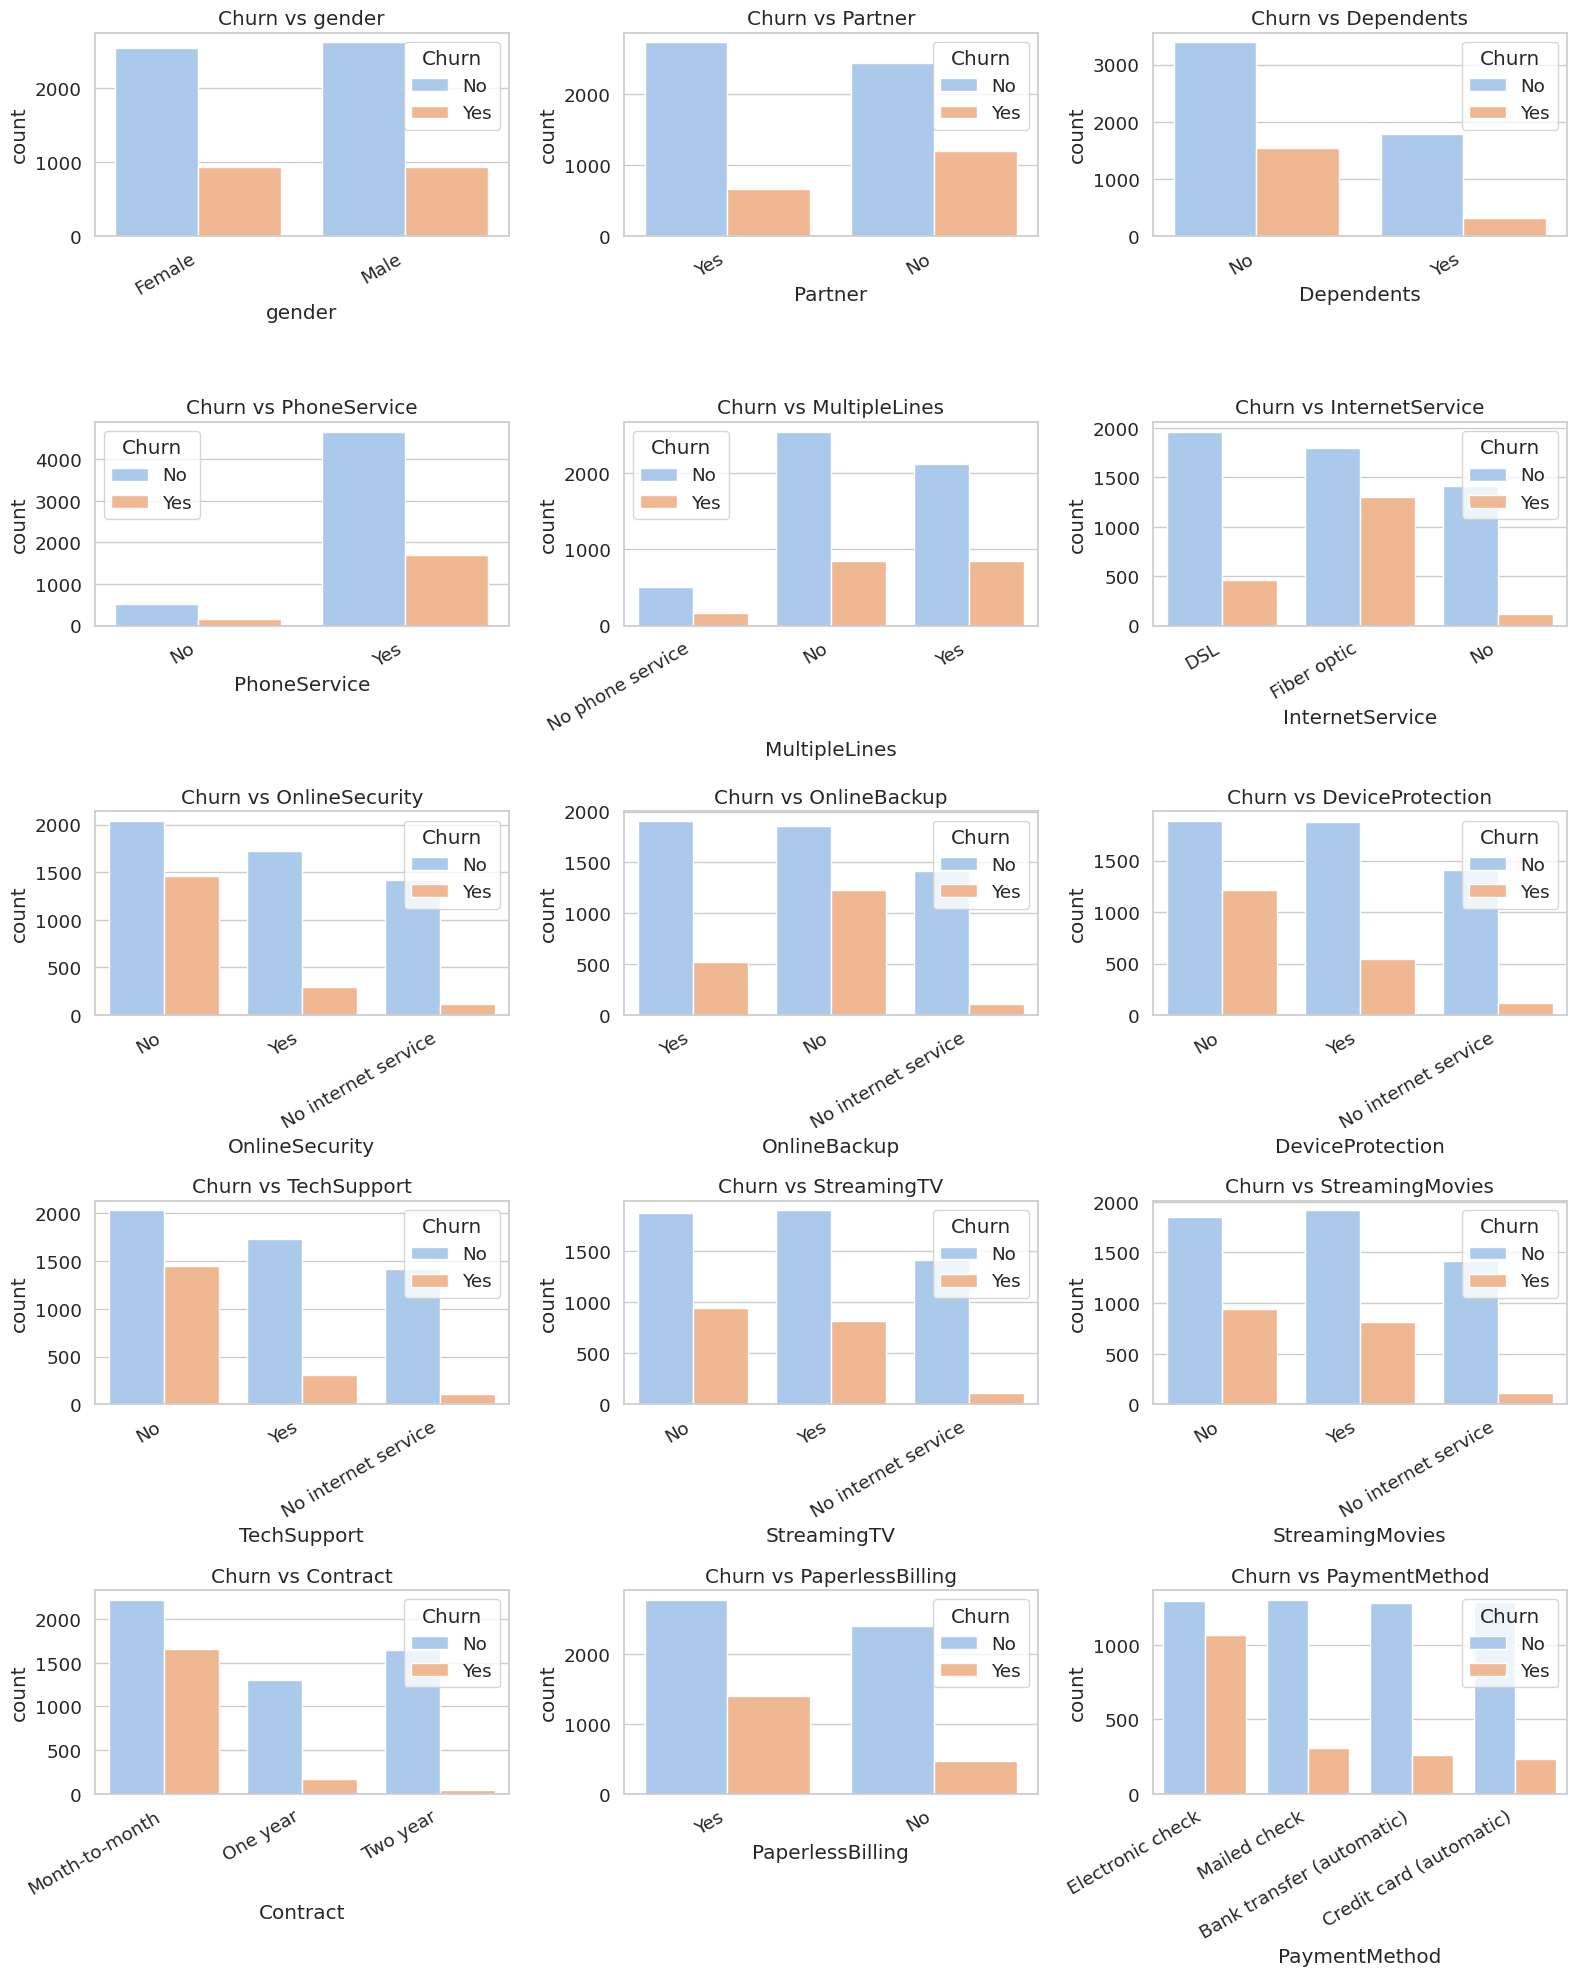

In [4]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("customerID")
cat_cols.remove("Churn")

plt.figure(figsize=(16, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(5, 3, i)
    sns.countplot(x=col, hue="Churn", data=df, palette="pastel")
    plt.xticks(rotation=30, ha="right")
    plt.title(f"Churn vs {col}")
plt.tight_layout()
plt.show()

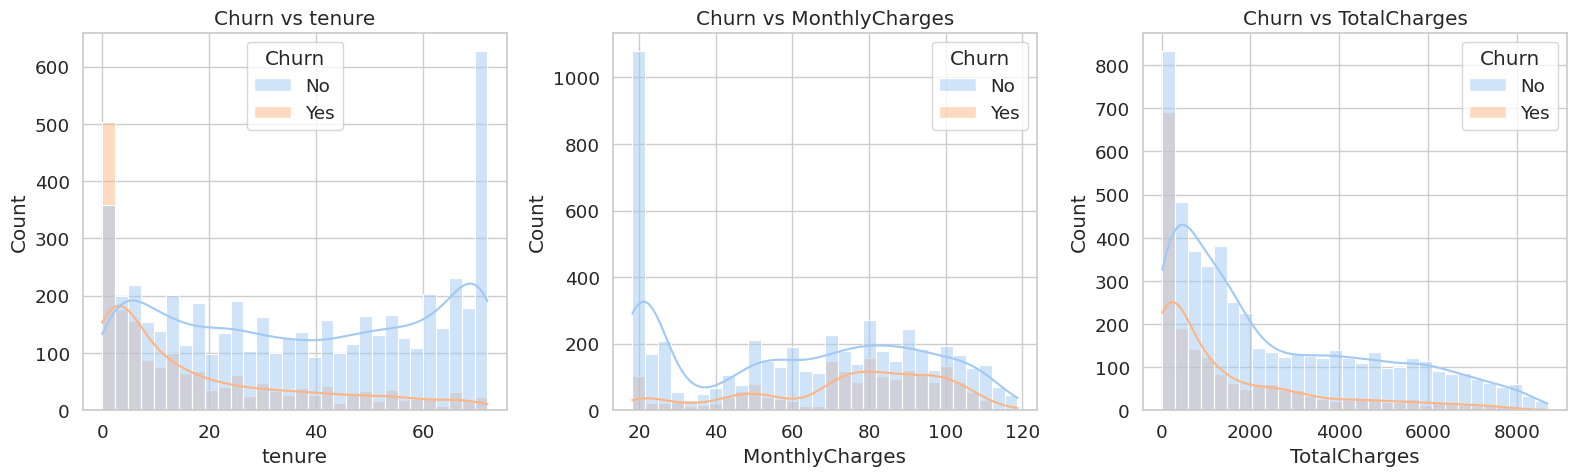

In [5]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(16, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df, x=col, hue="Churn", bins=30, kde=True, palette="pastel")
    plt.title(f"Churn vs {col}")
plt.tight_layout()
plt.show()

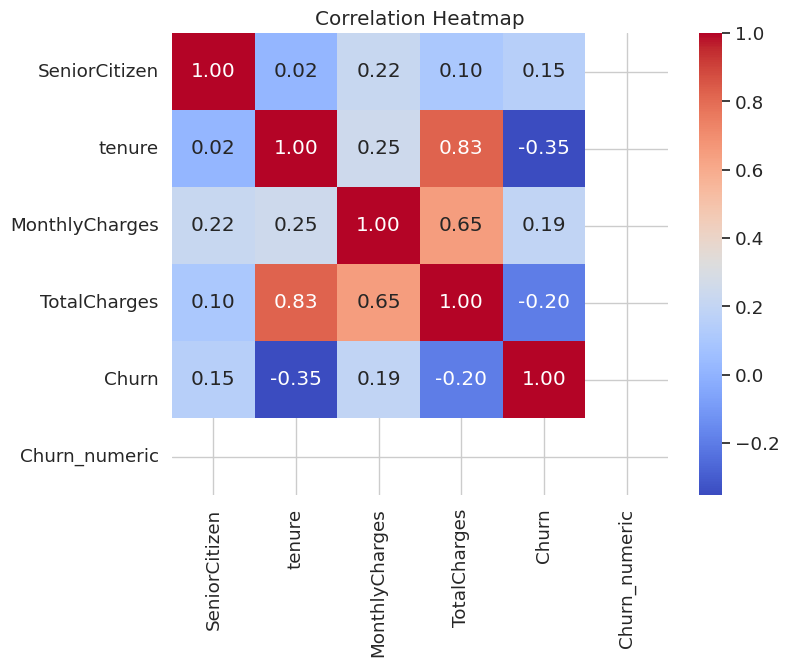

In [6]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(8,6))

df["Churn_numeric"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
corr = df[num_cols + ["Churn_numeric"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [7]:
print("Average tenure of churned customers:", df[df["Churn"]==1]["tenure"].mean())
print("Average tenure of retained customers:", df[df["Churn"]==0]["tenure"].mean())

Average tenure of churned customers: 17.979133226324237
Average tenure of retained customers: 37.56996521066873


STEP 2: Data Preprocessing

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan).astype(float)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = df.dropna(subset=['Churn'])

df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 7072)
Test shape: (1409, 7072)


STEP 3: BASELINE MODEL a. Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8034066713981547
Random Forest F1 Score: 0.5665101721439749


STEP 4 : ADV MODEL - XGBoost Classifier

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost F1 Score:", f1_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7849538679914834
XGBoost F1 Score: 0.5689900426742532


           Model  Accuracy  F1 Score
0  Random Forest  0.803407   0.56651
1        XGBoost  0.784954   0.56899


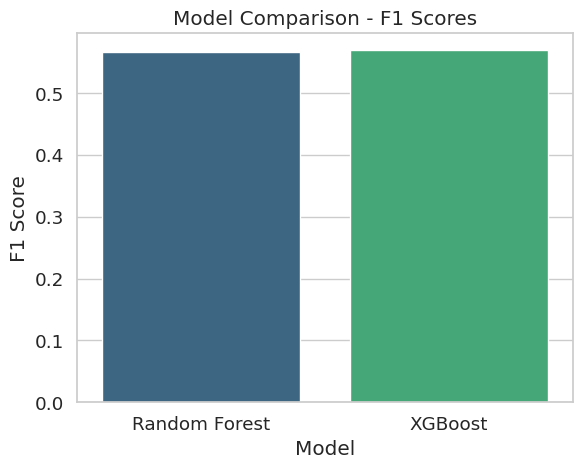

In [11]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
})

print(results)
sns.barplot(data=results, x='Model', y='F1 Score', hue='Model', palette='viridis')
plt.title("Model Comparison - F1 Scores")
plt.show()

STEP 5 : FEATURE IMPORTANCE

5.1 Random Forest Feature importance scaling

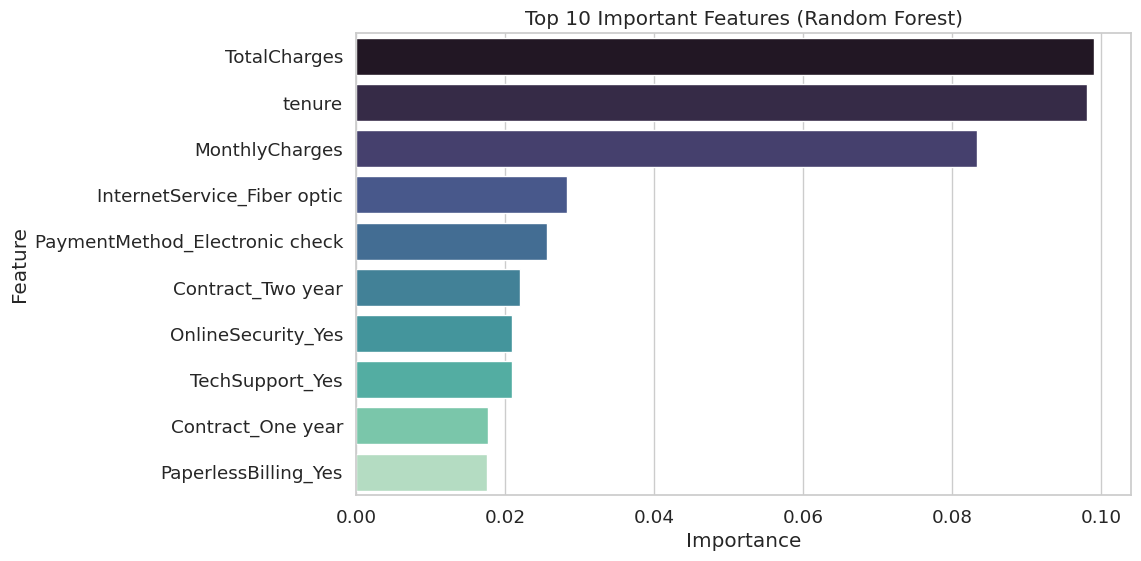

In [19]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(10), x='Importance', y='Feature', hue='Feature', palette='mako', legend=False)
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

5.2 XGBoost feature importance scaling

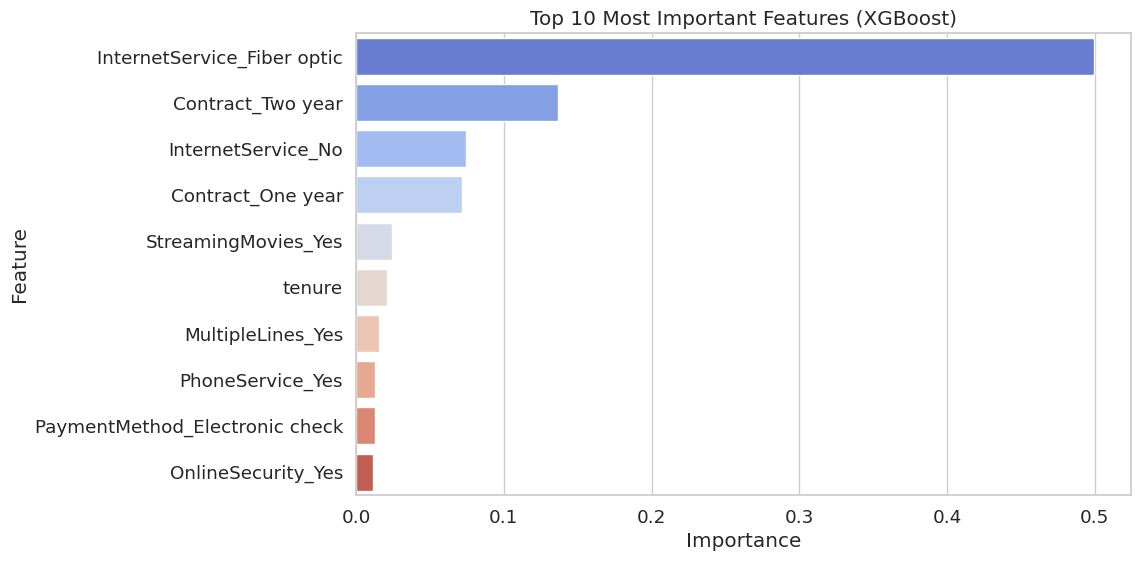

In [21]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', hue='Feature', palette='coolwarm', legend=False)
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

SHAP Features

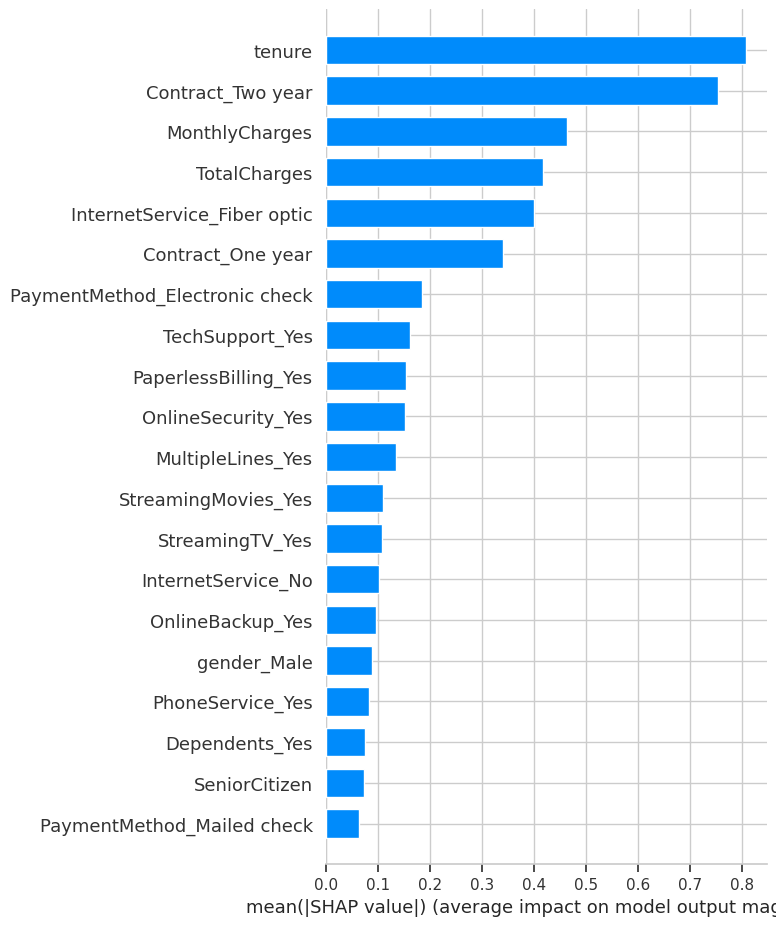

In [22]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

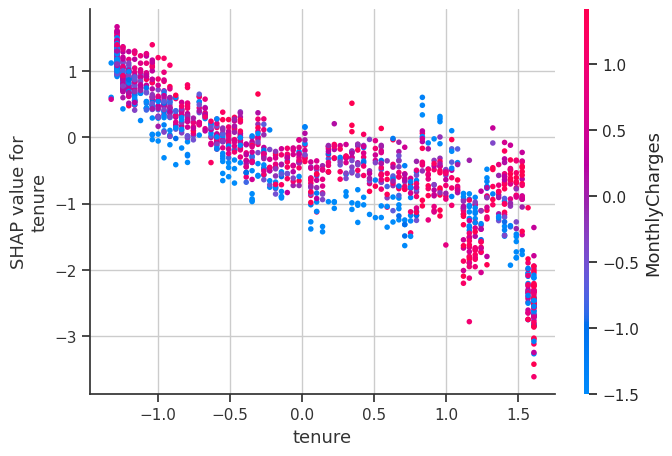

In [16]:
shap.dependence_plot("tenure", shap_values, X_test, interaction_index="MonthlyCharges")